In [1]:
import torch as tt
import torch.optim as oo
import torch.autograd as ag
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Identity(x): return x
class Linear:
    r""" https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear """

    @staticmethod
    def layout(in_features , out_features): 
        return \
        {
            f'weight' : (out_features, in_features),  
            f'bias'   : (out_features,            ),  
        }

    @staticmethod
    @tt.no_grad()
    def initialize(params:dict, in_features, generator=None, weight='weight', bias='bias'):
        k = (1/in_features)**0.5
        params[weight].uniform_(-k, k, generator=generator)
        params[bias].uniform_(-k, k, generator=generator)


    @staticmethod
    def forward(params, weight, bias, input): return tt.matmul(input, params[weight].T) + params[bias]

    @staticmethod
    def forwardF(params, weight, bias, actF, input): return actF(tt.matmul(input, params[weight].T) + params[bias])

    @staticmethod
    def shapes(batch_size, in_features, out_features): 
        return dict(
            in_shape = (batch_size, in_features), 
            out_shape = (batch_size, out_features),
        )


class MLP:

    def __init__(self, input_size, layer_sizes, output_size, activations) -> None:
        n_layers = len(layer_sizes)+1
        assert len(activations)==n_layers
        members = dict(
            input_size = input_size,
            layer_sizes = layer_sizes,
            output_size = output_size,
            activations = activations,
            n_layers = n_layers,
            )
        for k,v in members.items(): 
            if hasattr(self, k):    print(f'[{__class__}] already has attribute [{k}], value [{v}] will be skipped!')
            else:                   setattr(self, k, v)

    def layout(self):
        layer_sizes = [self.input_size] + self.layer_sizes + [self.output_size]
        full_layout = {}
        for i in range(len(layer_sizes)-1):
            l = Linear.layout( in_features=layer_sizes[i],  out_features=layer_sizes[i+1],)
            full_layout[f'weight_{i}'] = l.pop('weight')
            full_layout[f'bias_{i}'] = l.pop('bias')
        return full_layout

    def forward(self, params, input): 
        y = input
        for i in range(self.n_layers):
            y = Linear.forwardF(params, f'weight_{i}', f'bias_{i}', self.activations[i], y)
        return y
    
    def __call__(self, params:dict, *args, **kwargs): return self.forward(params, *args, **kwargs)

    def init(self, params, generator=None):
        for i in range(self.n_layers): Linear.initialize(params, self.input_size, generator, f'weight_{i}', f'bias_{i}')
          
    def shapes(self, batch_size):
        return Linear.shapes(batch_size, self.input_size, self.output_size)

    def params(self, requires_grad=True, dtype=None, device=None) -> dict:
        r""" use to create a new dict of parameters from current layout """
        return {name : tt.zeros(size=size, dtype=dtype, device=device, requires_grad=requires_grad) for name, size in self.layout().items() }



class Modular(object):

    @staticmethod
    def count(params:dict, requires_grad=None): 
        r""" Counts the total number of parameters (numel) in a params
        
        :param requires_grad: 
            if None, counts all parameters
            if True, counts trainable parameters
            if False, counts non-trainiable (frozen) parameters
        """
        return sum( ([ p.numel() for p in params.values() ]) if requires_grad is None else \
                    ([ p.numel() for p in params.values()    if p.requires_grad is requires_grad ]) )

    @staticmethod
    def show(params:dict, values:bool=False):
        r""" Prints the parameters of a params
        
        :param values: if True, prints the full tensors otherwise prints only shape
        """
        nos_trainable, nos_frozen = 0, 0
        print('=====================================')
        for i,(n,p) in enumerate(params.items()):
            iparam = p.numel()
            if p.requires_grad:
                nos_trainable += iparam
            else:
                nos_frozen += iparam
            print(f'#[{i}]\t{n}\tShape[{p.shape}]\tParams: {iparam}\tTrainable: {p.requires_grad}')
            if values: 
                print('=====================================')
                print(f'{p}')
                print('=====================================')
        print(f'\nTotal Parameters: {nos_trainable+nos_frozen}\tTrainable: {nos_trainable}\tFrozen: {nos_frozen}')
        print('=====================================')
        return 

    @staticmethod
    @tt.no_grad()
    def diff(params1:dict, params2:dict, do_abs:bool=True, do_sum:bool=True):
        r""" Checks the difference between the parameters of two modules.
            This can be used to check if two models have exactly the same parameters.

        :param do_abs: if True, finds the absolute difference
        :param do_sum: if True, finds the sum of difference

        :returns: a list of differences in each parameter or their sum if ``do_sum`` is True.
        """
        d = [ (abs(p1 - p2) if do_abs else (p1 - p2)) for p1,p2 in zip(params1.values(), params2.values()) ]
        if do_sum: d = [ tt.sum(p) for p in d  ]
        return d

    @staticmethod
    @tt.no_grad()
    def copy(params_from:dict, params_to:dict) -> None:
        r""" Copies the parameters of a params to another - both modules are supposed to be identical"""
        for pt,pf in zip(params_to.values(), params_from.values()): pt.copy_(pf)

    @staticmethod
    def apply(params:dict, fn, *args, **kwargs):
        r""" apply a function on parameters and return new set of parameters (NOTE: not using no_grad())"""
        return {k:fn(p, *args, **kwargs) for k,p in params.items()} 

    @staticmethod
    @tt.no_grad()
    def apply_(params:dict, fn, *args, **kwargs):
        r""" apply an inplace operation 
        
        NOTE: this can be use to initialize randomly 
            param.bernoulli_            (p=0.5)                             # p can be tensor a well
            param.cauchy_               (median=0.0, sigma=1.0)
            param.exponential_          (lambd=1.0)
            param.geometric_            (p=0.5)
            param.log_normal_           (mean=1.0, std=2.0)
            param.normal_               (mean=0.0, std=1.0)
            param.random_               (from_=0, to=10)                    # int arguments
            param.uniform_              (from_=0.0, to=1.0)
        """
        for p in params.values(): fn(p, *args, **kwargs)

    @staticmethod
    @tt.no_grad()
    def clone(params:dict, requires_grad=True, memory_format=None):
        r""" Clones a params by creating copies of parameters using the Tensor.clone() call
        No need for .detach() call since we clone with tt.no_grad()
        NOTE: this will preserve the ```require_grad``` attribute on all tensors if arg ```requires_grad``` is True """
        if requires_grad:
            return {n:p.clone(memory_format=memory_format).requires_grad_(p.requires_grad) for n,p in params.items()}
        else:
            return {n:p.clone(memory_format=memory_format).requires_grad_(False) for n,p in params.items()} # force no grad

    @staticmethod
    @tt.no_grad()
    def duplicate(params:dict, copy=True, requires_grad=True, memory_format=None) -> None:
        r""" Duplicates a params by creating copies of parameters using zeros_like() call and copies values if arg  ```copy``` is True
        NOTE: this will preserve the ```require_grad``` attribute on all tensors if arg ```requires_grad``` is True """
        if copy:
            if requires_grad:
                return {n: tt.zeros_like(p, memory_format=memory_format, requires_grad=p.requires_grad).copy_(p) for n,p in params.items()} 
            else:
                return {n: tt.zeros_like(p, memory_format=memory_format,requires_grad=False).copy_(p) for n,p in params.items()} # force no grad
        else:
            if requires_grad:
                return {n: tt.zeros_like(p, memory_format=memory_format,requires_grad=p.requires_grad) for n,p in params.items()}
            else:
                return {n: tt.zeros_like(p, memory_format=memory_format,requires_grad=False) for n,p in params.items()}

    @staticmethod
    def replicate(params:dict, n_copies:int=1):
        r""" Replicates a params by storing it in a buffer and retriving many copies
        NOTE: this will preserve the ```require_grad``` attribute on all tensors. """
        from io import BytesIO
        buffer = BytesIO()
        tt.save(params, buffer)
        model_copies = []
        for _ in range(n_copies):
            buffer.seek(0)
            model_copy = tt.load(buffer)
            model_copies.append(model_copy)
        buffer.close()
        del buffer
        return model_copy if n_copies==1 else model_copies

    @staticmethod
    def requires_grad(params:dict, requires:bool, *names):
        r""" Sets requires_grad attribute on tensors in params
        if no names are provided, sets requires_grad on all tensors """
        if names:
            for n in names: params[n].requires_grad_(requires)
        else: 
            for p in params.values(): p.requires_grad_(requires)

    @staticmethod
    def zeros(layout, requires_grad=True, dtype=None, device=None) -> dict:
        r""" use to create a new dict of parameters from given layout::dict[str, size(tuple)] """
        return {name : tt.zeros(size=size, dtype=dtype, device=device, requires_grad=requires_grad) for name, size in layout.items() }
    
    @staticmethod
    def zeros_like(params:dict, memory_format=None) -> dict:
        r""" use to create a new dict of parameters from given layout::dict[str, size(tuple)] """
        return {name : tt.zeros_like(value, memory_format=memory_format, requires_grad=value.requires_grad) for name, value in params.items() }
    
    @staticmethod
    def save(params:dict, path:str): tt.save(params, path)

    @staticmethod
    def load(path:str): return tt.load(path)




# create MLP

In [3]:
batch_size = 5
input_size = 1
output_size = 1
dtype = tt.float32
lossF = tt.nn.MSELoss()

In [4]:
model = MLP(
    input_size=input_size, 
    layer_sizes=[64,64,64],
    output_size=output_size,
    activations=(tt.sigmoid, tt.tanh, tt.relu, Identity)
)


Data Split

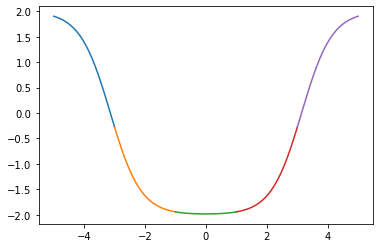

In [12]:
num_clients = 5
PHASE, AMP = np.pi, 2.0
clients = {}
lb, ub, total_size= -5, 5, 100
bound_size = int((ub-lb)/num_clients)
for i in range(num_clients):
    LB= lb + i * bound_size
    UB = LB + bound_size
    x = tt.linspace(LB, UB, int(total_size/num_clients)).to(dtype=dtype).unsqueeze(-1)
    # Y = (tt.sin(X+PHASE)*AMP).to(dtype=dtype)
    y = ((tt.tanh(x+PHASE)*tt.tanh(x-PHASE)*AMP)).to(dtype=dtype)

    plt.plot(x,y)
    clients[f'client_{i}'] = tt.hstack((x,y))
    # dataset = tt.hstack((X,Y))
    # plt.show()
# clients

Per-FedAvg

In [15]:

params = model.params(requires_grad=True, dtype=dtype)
# for k,v in params.items():print(k, v.shape)
model.init(params)
w_k = params # step 1; w_0
r = 1 # fraction of active user; r=1 signifies that all the users are active
K = 50 # number of global rounds
for k in range (0,K):
    for user in clients:
        w_i_k_1 = w_k.
        for 

    